In [1]:
# importing the requests library 
import requests 
import pandas as pd
from random import sample 
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                                                             
import sys
import scipy

## General notes:

#### Annotation Error Propigation
To what extent is error being propigated through the annotation network? If a genome is annotated inncorrectly will the next genome that is similiair grab that error? Anotation of one genome IS DEPENDENT on current annoatated genomes. If a gene is annotated how likely is it to take on the same info as previously annotated genes. Does unique spelling errors show independent thought, likewise, does non-unique misspelled annotations show dependence.

#### Evolution or Functionality?
As shown in the analysis below phams are very specific to cluster. That being said does that mean a gene from one cluster will not work in a genome from another cluster? Or is this because of evolutionary lineage?


In [2]:
df_genes = pd.read_csv("all_phage_genes.csv")
df_genes.head()

,GeneID,HostStrain,Cluster,Pham,Function,Translation,Orientation,PhageName,GeneNumber
0,20ES_CDS_1,Mycobacterium,A2,36676,NaN,MYGTRSSAFWASQPGKFDVLNLRMTFPSTSAHEIPDLTATDFVPEN...,F,20ES,1
1,20ES_CDS_10,Mycobacterium,A2,34452,lysin B,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,F,20ES,10
2,20ES_CDS_11,Mycobacterium,A2,34196,terminase,MSLENHHPELAPSPPHIIGPSWQRTVDGSWHLPDPKMTLGWGVLKW...,F,20ES,11
3,20ES_CDS_12,Mycobacterium,A2,37970,portal protein,MTAPLPGQEEIPDPAIARDEMISAFDDAVKNLKINTSYYEAERRPE...,F,20ES,12
4,20ES_CDS_13,Mycobacterium,A2,21454,capsid maturation protease,MITAAVAAYVQRFASMFTGPALSLGEWARFLQTLFPEVQRRYAQAA...,F,20ES,13


In [3]:
df_genes = df_genes.applymap(str)
df_genes.describe(include = 'all')

,GeneID,HostStrain,Cluster,Pham,Function,Translation,Orientation,PhageName,GeneNumber
count,348351,348351,348351,348351,348351,348351,348351,348351,348351
unique,348351,14,274,23208,1788,155628,2,3510,352
top,Gadost_CDS_38,Mycobacterium,C1,34452,nan,MTDQTHEAPPVPRYLSRDEVAKRLGMKSVRSLSGIELPPPDVEVGK...,F,PauloDiaboli,8
freq,1,215767,33229,1055,244309,211,247473,352,3510


In [4]:
df_genes["Cluster"].unique()

array(['A2', 'E', 'Z', 'B6', 'A17', 'BD1', 'AO3', 'BL', 'A4', 'AS1', 'B3',
       'A1', 'B1', 'BG', 'B5', 'A3', 'L1', 'K1', 'AX', 'AV', 'EP', 'CS2',
       'C1', 'D1', 'AZ', 'CZ4', 'EF', 'DE1', 'CT', 'A5', 'N', 'F1', 'EK2',
       'DJ', 'EA5', 'B4', 'CA', 'EB', 'AK', 'DZ', 'EK1', 'EA1', 'DE2',
       'A9', 'ED1', 'K5', 'BD3', 'BD2', 'AS2', 'K6', 'AQ', 'K7', 'Q',
       'CS1', 'CS3', 'BV', 'DR', 'AS3', 'EA2', 'A11', 'CY1', 'G1', 'FD',
       'BK1', 'A15', 'EC', 'A20', 'CZ1', 'G5', 'CQ1', 'GA', 'DN3', 'BU',
       'BH', 'EM', 'B2', 'AN', 'AM', 'L2', 'DA', 'CV', 'W', 'P1', 'J',
       'EE', 'DC1', 'A6', 'AR', 'nan', 'DN1', 'CS4', 'A8', 'CZ2', 'FC',
       'BC3', 'AY', 'F2', 'G2', 'DI', 'M2', 'BW', 'I1', 'EG', 'GE', 'CU1',
       'DL', 'H2', 'AO2', 'BE2', 'CZ3', 'DB', 'FJ', 'AO1', 'AT', 'H1',
       'CY', 'S', 'T', 'DG1', 'P4', 'BK2', 'BI5', 'CR4', 'Y', 'B13', 'O',
       'FE', 'BE1', 'K4', 'M1', 'DS', 'K2', 'AU1', 'FA', 'CY2', 'L4',
       'CQ2', 'CR2', 'FH', 'CZ', 'EA4', 'EN', 'EL', 'R',

#### WHY AM I NOT GETTING PHAM CLUSTER OVERLAP?? fixed this bug, good sanity check

If phams were only filled with a particular subcluster then using phagesdb gene content would be trival. Burton (A1) 27% GCS with Phlei (A13)

In [5]:
Burton = df_genes[df_genes["PhageName"]=="Burton"][["GeneID","Pham"]]
Burton["Pham"] = Burton["Pham"].astype(int) 
Burton.head()

,GeneID,Pham
47648,Burton_CDS_1,17389
47649,Burton_CDS_10,27713
47650,Burton_CDS_11,5003
47651,Burton_CDS_12,34196
47652,Burton_CDS_13,37970


In [6]:
Phlei = df_genes[df_genes["PhageName"]=="Phlei"][["GeneID","Pham"]]
Phlei["Pham"] = Phlei["Pham"].astype(int) 
Phlei.head()

,GeneID,Pham
242207,Phlei_CDS_1,36593
242208,Phlei_CDS_10,21454
242209,Phlei_CDS_11,8023
242210,Phlei_CDS_12,15229
242211,Phlei_CDS_13,32968


In [7]:
phams_phlei = list(sorted(Phlei["Pham"]))
for i in list(sorted(Burton["Pham"])):
    if i in phams_phlei:
        print(i)

2168
3047
3085
7918
8904
11130
15206
19586
21454
21699
25312
25315
27102
31307
32968
33152
33680
34163
34178
34196
35764
36600
37096
37435
37970


### Construct our graph

In [8]:
G = nx.Graph()
for index, row in df_genes.iterrows():
    function = row['Function']
    pham = row['Pham']
    subcluster = row['Cluster']
    phage = row["PhageName"]
    cluster = ""
    for i in row['Cluster']:
        if not i.isdigit():
            cluster+=i
    # ADD PHAM NODE iF it doesn't exist
    if not G.has_node(pham):
        G.add_node(pham, group='pham', clusters=[cluster], subclusters=[subcluster], phages=[phage], freq = 1)
    else:
        G.nodes[pham]["freq"] += 1
        G.nodes[pham]["clusters"].append(cluster)
        G.nodes[pham]["subclusters"].append(subcluster)
        G.nodes[pham]["phages"].append(phage)
        
#     if pham == "21454":
#         print(row["PhageName"],row['Cluster'])
#         print(G.nodes[pham]["clusters"])
    # ADD FUNCTION NODE iF it doesn't exist
    if not G.has_node(function):
        G.add_node(function, group='function', clusters=[cluster], subclusters=[subcluster], phages=[phage], freq = 1)
    else:
        G.nodes[function]["freq"] += 1
        G.nodes[function]["clusters"].append(cluster)
        G.nodes[function]["subclusters"].append(subcluster)
        G.nodes[function]["phages"].append(phage)
            
    # ADD EDGE if it doesn't exist or increase weight     
    if G.has_edge(pham, function):
        G.edges[pham, function]["weight"] += 1  
    else:
        G.add_edge(pham, function, weight = 1)
        


In [53]:
nx.write_gml(G, "bipartite_pham_func.gml")

### Lets validate the graph was made correctly

In [9]:
function_count = 0
pham_count = 0

for i in G.nodes():
    if G.nodes[i]["group"] == "function":
        function_count += 1
    else:
        pham_count += 1
        
print("Pham count from Network:", pham_count, "--- Actual Count from df:",df_genes["Pham"].nunique())
print("Function count from Network:", function_count, "--- Actual Count from df:",df_genes["Function"].nunique())

Pham count from Network: 23208 --- Actual Count from df: 23208
Function count from Network: 1788 --- Actual Count from df: 1788


In [10]:
n = G.number_of_nodes()#function for number of nodes
m = G.size() #function for number of edges
kmean = m*2/n #mean of in directed degree is edges/number of nodes

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)

number of nodes, n  = 24996
number of edges, m  = 30119
mean degree,    <k> =  2.41


In [11]:
kmean_function = m/function_count
kmean_pham = m/pham_count
print(f'mean degree for function,    <k> = %5.2f' % kmean_function)
print(f'mean degree for pham   <k> = %5.2f' % kmean_pham)

mean degree for function,    <k> = 16.85
mean degree for pham   <k> =  1.30


This means that most phams are only attached to 1 function, with exception. While must functions are attached to multiple phams, which makes sense for the hypothesis that pham is a subset of function. We also guess that all phams are connected to one function, but it appears as multiple due to mispellings.


#### Are the phams connected to multiple functions due to misspellings?

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-395

Pham calculations

We conclude that inclusion of BLASTP contributes rather little to the pham assembly process, but that a combination of a CLUSTALW threshold of 32.5% and a BLASTP cut off of 10-50 offers optimal parameters for this dataset, building phams of homologous proteins while minimizing construction of complex phams in which only segments of the proteins are related to each other.

In [12]:
for i in G.nodes():
    if G.nodes[i]["group"] == "pham" and len(list(G.neighbors(i)))>1:
        print("PHAM:", i)
        neighbors = list(G.neighbors(i))
        for ne in neighbors:
            print("\t Functions:", ne)

PHAM: 36676
	 Functions: nan
	 Functions: VIP2 protein
	 Functions: queuine tRNA-ribosyltransferase
PHAM: 34452
	 Functions: lysin B
	 Functions: nan
	 Functions: LysB
	 Functions: lysB
	 Functions: Lysin B
	 Functions: lysin b
PHAM: 34196
	 Functions: terminase
	 Functions: terminase large subunit
	 Functions: terminase, large subunit
	 Functions: nan
	 Functions: lysin B
	 Functions: putative terminase protein
	 Functions: putative large terminase subunit
	 Functions: terminase large subunt
	 Functions: Terminase
	 Functions: putative terminase
PHAM: 37970
	 Functions: portal protein
	 Functions: nan
	 Functions: Portal
	 Functions: putative portal protein
PHAM: 21454
	 Functions: capsid maturation protease
	 Functions: nan
	 Functions: capsid assembly protease
	 Functions: protease
	 Functions: MuF-like minor capsid protein
	 Functions: head assembly protease
	 Functions: minor capsid protein
	 Functions: putative head assembly protein
	 Functions: capsid maturation protein
	 Functi

	 Functions: nan
	 Functions: membrane domain protein
PHAM: 35356
	 Functions: nan
	 Functions: DnaB-like dsDNA helicase
	 Functions: DnaB-like helicase
PHAM: 37684
	 Functions: nan
	 Functions: chorismate mutase domain of P-protein
	 Functions: membrane domain protein
PHAM: 37146
	 Functions: nan
	 Functions: DprA-like DNA processing chain A
	 Functions: DNA recombinase
	 Functions: DNA binding protein
	 Functions: phosphoribosyltransferase
	 Functions: ssDNA binding protein
	 Functions: DrpA-like ssDNA binding protein
	 Functions: helicase
	 Functions: HNH endonuclease
	 Functions: DrpA-like ssDNA-binding protein
	 Functions: DNA processing chain A
	 Functions: DNA processing chain protein
	 Functions: dprA-like single stranded DNA binding protein
	 Functions: DNA processing protein
	 Functions: drpA-like ssDNA binding protein
	 Functions: DprA-like DNA processing chain
	 Functions: dsDNA helicase
	 Functions: drpA-like ssDNA-binding protein
	 Functions: phosphoribosyl transferase
	 

PHAM: 20287
	 Functions: nan
	 Functions: major tail protein
	 Functions: tail protein
	 Functions: minor tail protein
PHAM: 3845
	 Functions: tail assembly chaperone
	 Functions: nan
	 Functions: putative tail chaperone
PHAM: 33589
	 Functions: tail assembly chaperone
	 Functions: tail assembly chaperone protein
PHAM: 9319
	 Functions: tapemeasure
	 Functions: tape measure protein
	 Functions: nan
	 Functions: tapemeasure protein
	 Functions: tape measure
	 Functions: putative tail tape measure
PHAM: 34970
	 Functions: nan
	 Functions: minor tail protein
	 Functions: tail protein
	 Functions: major tail protein
PHAM: 32588
	 Functions: nan
	 Functions: minor tail protein
	 Functions: putative tail protease
PHAM: 34652
	 Functions: nan
	 Functions: minor tail protein
	 Functions: putative tail fiber protein
PHAM: 37397
	 Functions: nan
	 Functions: minor tail protein
	 Functions: chaperone of endosialidase
	 Functions: tail fiber protein
	 Functions: tail fiber
PHAM: 30060
	 Functions:

	 Functions: DNA binding protein
PHAM: 11546
	 Functions: nan
	 Functions: membrane domain protein
PHAM: 10265
	 Functions: nan
	 Functions: putative structural protein
PHAM: 21734
	 Functions: queuine-tRNA ribosyltransferase
	 Functions: queuine tRNA-ribosyltransferase
	 Functions: nan
	 Functions: dpdA-like tRNA-guanine transglycosylase
PHAM: 8984
	 Functions: nan
	 Functions: tape measure
PHAM: 19994
	 Functions: minor tail protein
	 Functions: nan
	 Functions: minor tail subunit
PHAM: 3445
	 Functions: minor tail protein
	 Functions: nan
	 Functions: minor tail subunit
PHAM: 33906
	 Functions: lysin A
	 Functions: nan
	 Functions: lysin A, amidase domain
PHAM: 13894
	 Functions: lysin B
	 Functions: nan
PHAM: 13974
	 Functions: nan
	 Functions: HNH endonuclease
PHAM: 13663
	 Functions: nan
	 Functions: HNH endonuclease
PHAM: 14346
	 Functions: nan
	 Functions: RDF protein
	 Functions: recombination directionality factor
PHAM: 15228
	 Functions: nan
	 Functions: RnaseE-like protein


PHAM: 31878
	 Functions: DNA polymerase I
	 Functions: nan
PHAM: 15023
	 Functions: recA-like recombinase
	 Functions: RecA-like recombinase
PHAM: 19150
	 Functions: AAA ATPase
	 Functions: ATPase
PHAM: 3821
	 Functions: recB-like exonuclease
	 Functions: RecB-like exonuclease
PHAM: 37977
	 Functions: nan
	 Functions: DNA binding protein
PHAM: 4852
	 Functions: HNH endonuclease
	 Functions: nan
	 Functions: HNH endonuclease domain protein
PHAM: 5804
	 Functions: nan
	 Functions: head-to-tail connector protein
	 Functions: head-to-tail connector complex protein
PHAM: 9858
	 Functions: major tail protein
	 Functions: nan
	 Functions: gp12, major tail protein
	 Functions: major tail subunit
PHAM: 14659
	 Functions: tail assembly chaperone
	 Functions: pre-TMP frameshift protein
PHAM: 25506
	 Functions: nan
	 Functions: minor tail protein
PHAM: 32676
	 Functions: endolysin
	 Functions: lysin A
	 Functions: putative lysin
PHAM: 2983
	 Functions: tyrosine integrase
	 Functions: integrase
PHA

	 Functions: nan
	 Functions: helix-turn-helix DNA binding domain protein
PHAM: 14617
	 Functions: nan
	 Functions: minor tail protein
PHAM: 35536
	 Functions: nan
	 Functions: minor tail protein
PHAM: 4249
	 Functions: nan
	 Functions: D-ala-D-ala-carboxypeptidase
	 Functions: minor tail protein
	 Functions: D-Ala-D-Ala carboxypeptidase
	 Functions: minor tail protein, D-ala-D-ala carboxypeptidase
PHAM: 35111
	 Functions: lysin A
	 Functions: lysin A, L-Ala-D-Glu peptidase domain
	 Functions: lysin A, protease M15 domain
	 Functions: lysin A, L-ala D-glu peptidase domain
	 Functions: major tail subunit
	 Functions: nan
	 Functions: lysin A, l-ala d-glu peptidase domain
	 Functions: LysA
	 Functions: endolysin
	 Functions: putative lysin
PHAM: 19110
	 Functions: nan
	 Functions: holin
PHAM: 8491
	 Functions: nan
	 Functions: lysin B
PHAM: 15798
	 Functions: nan
	 Functions: hydrolase
PHAM: 32898
	 Functions: helicase
	 Functions: DNA helicase
	 Functions: nan
	 Functions: putative heli

	 Functions: helicase
	 Functions: nan
	 Functions: DNA/RNA helicase
PHAM: 9550
	 Functions: RecA-like DNA recombinase
	 Functions: nan
	 Functions: RepA
	 Functions: primase
	 Functions: RecA
	 Functions: DNA primase/helicase
PHAM: 15126
	 Functions: MuF-like minor capsid protein
	 Functions: capsid maturation protease
	 Functions: nan
	 Functions: head assembly protein
	 Functions: capsid maturation protease and MuF-like fusion protein
	 Functions: minor capsid protein
	 Functions: head maturation protease
	 Functions: protease
PHAM: 30051
	 Functions: nan
	 Functions: ankyrin
PHAM: 37846
	 Functions: scaffolding protein
	 Functions: nan
PHAM: 32320
	 Functions: major capsid protein
	 Functions: nan
	 Functions: main capsid protein
PHAM: 2283
	 Functions: head-to-tail adaptor
	 Functions: nan
	 Functions: head-to-tail connector protein
	 Functions: head-to-tail connector complex protein
	 Functions: head-to-tail connector
	 Functions: HTH adaptor
PHAM: 30136
	 Functions: minor tail p

	 Functions: nan
	 Functions: ADP-ribosyl glycohydrolase
	 Functions: glycohydrolase
PHAM: 33999
	 Functions: nan
	 Functions: major tail protein
	 Functions: major tail subunit
	 Functions: putative major tail protein
	 Functions: main tail protein
	 Functions: putative structural protein
PHAM: 35831
	 Functions: nan
	 Functions: minor tail protein
PHAM: 34080
	 Functions: nan
	 Functions: minor tail protein
PHAM: 35755
	 Functions: nan
	 Functions: minor tail protein
	 Functions: tail protein
PHAM: 32228
	 Functions: nan
	 Functions: lysin A, protease C39 domain
	 Functions: lysin A, cysteine protease domain
	 Functions: lysin A
	 Functions: lysin A, protease M15 domain
	 Functions: lysin A, L-Ala-D-Glu peptidase domain
	 Functions: lysin A protease C39 domain
	 Functions: putative peptidase
	 Functions: putative lysis enzyme
	 Functions: putative lysis protein
	 Functions: putative lysin
	 Functions: lysin A, C39 peptidase domain
	 Functions: lysin A, protease domain
	 Functions: en

PHAM: 2803
	 Functions: minor tail protein
	 Functions: nan
PHAM: 4107
	 Functions: helix-turn-helix DNA binding protein
	 Functions: helix-turn-helix DNA binding domain protein
	 Functions: excise
	 Functions: nan
	 Functions: HTH DNA binding protein
PHAM: 2429
	 Functions: nan
	 Functions: lipoprotein
PHAM: 34917
	 Functions: nan
	 Functions: lipoyl synthase
PHAM: 20130
	 Functions: methyltransferase
	 Functions: nan
PHAM: 9799
	 Functions: helix-turn-helix DNA binding domain protein
	 Functions: immunity repressor
	 Functions: Cro protein
PHAM: 33543
	 Functions: antirepressor
	 Functions: nan
	 Functions: antirepressor protein
	 Functions: putative antirepressor
	 Functions: phage antirepressor
PHAM: 38049
	 Functions: nan
	 Functions: DNA polymerase III beta subunit
	 Functions: DNA polymerase III sliding clamp (Beta)
	 Functions: DNA polymerase III sliding clamp
PHAM: 10304
	 Functions: scaffolding protein
	 Functions: nan
PHAM: 5856
	 Functions: nan
	 Functions: helix-turn-helix

	 Functions: putative NrdG
	 Functions: 7-cyano-7-deazaguanosine
PHAM: 2663
	 Functions: GTP cyclohydrolase I
	 Functions: nan
	 Functions: hydrolase
	 Functions: putative T-Fold protein
PHAM: 22467
	 Functions: nan
	 Functions: helix-turn-helix DNA binding protein
PHAM: 32458
	 Functions: tape measure protein
	 Functions: putative tape measure protein
PHAM: 33536
	 Functions: holin
	 Functions: nan
PHAM: 9400
	 Functions: nan
	 Functions: helix-turn-helix DNA binding domain protein
PHAM: 32211
	 Functions: helix-turn-helix DNA binding domain protein
	 Functions: immunity repressor
PHAM: 14719
	 Functions: minor tail protein
	 Functions: nan
	 Functions: tail protein
PHAM: 8861
	 Functions: minor tail protein
	 Functions: nan
	 Functions: tail protein
PHAM: 32080
	 Functions: nan
	 Functions: holin
PHAM: 10931
	 Functions: acetyltransferase
	 Functions: nan
PHAM: 13569
	 Functions: helix-turn-helix DNA-binding domain protein
	 Functions: nan
PHAM: 33458
	 Functions: endolysin
	 Functio

	 Functions: holliday junction resolvase
	 Functions: endonuclease
	 Functions: DNA binding protein
	 Functions: nan
	 Functions: DNA binding domain protein
PHAM: 4907
	 Functions: nan
	 Functions: AlpA
	 Functions: helix-turn-helix DNA binding domain protein
PHAM: 27145
	 Functions: glycosyltransferase
	 Functions: nan
	 Functions: glycosyltransferase/methyltransferase
PHAM: 21927
	 Functions: glycosyltransferase
	 Functions: nan
	 Functions: galactosyltransferase
	 Functions: polypeptide N-acetylgalactosaminyltransferase
	 Functions: n-acetylglucosaminyltransferase
PHAM: 36078
	 Functions: minor tail protein
	 Functions: nan
PHAM: 36566
	 Functions: minor tail protein
	 Functions: nan
PHAM: 35617
	 Functions: minor tail protein
	 Functions: nan
PHAM: 14124
	 Functions: nan
	 Functions: queuine tRNA-ribosyltransferase
PHAM: 37832
	 Functions: nan
	 Functions: helix-turn-helix DNA binding domain
	 Functions: helix-turn-helix DNA binding domain protein
	 Functions: helix-turn-helix DNA 

	 Functions: helix-turn-helix DNA binding protein
	 Functions: helix-turn-helix DNA binding domain
PHAM: 6036
	 Functions: DNA binding domain protein
	 Functions: helix-turn-helix DNA-binding domain protein
	 Functions: nan
	 Functions: helix-turn-helix DNA binding domain
PHAM: 22928
	 Functions: helix-turn-helix DNA binding protein
	 Functions: helix-turn-helix DNA binding domain
	 Functions: nan
PHAM: 21204
	 Functions: nan
	 Functions: exonuclease
PHAM: 2819
	 Functions: Cas4 family exonuclease
	 Functions: nan
	 Functions: exonuclease
PHAM: 29984
	 Functions: DNA recombinase
	 Functions: nan
	 Functions: RecA-like DNA recombinase
	 Functions: RAD 52-like DNA recombinase
PHAM: 9770
	 Functions: DNA primase
	 Functions: nan
	 Functions: helicase
PHAM: 21821
	 Functions: RepA-like replication initiator
	 Functions: nan
	 Functions: HTH DNA binding domain protein
PHAM: 12408
	 Functions: helix-turn-helix DNA binding domain protein
	 Functions: nan
	 Functions: helix-turn-helix DNA-bind

	 Functions: HNH endonuclease domain protein
	 Functions: nan
	 Functions: HNH endonuclease
PHAM: 3670
	 Functions: hydrolase
	 Functions: lipase
	 Functions: minor tail protein
PHAM: 15628
	 Functions: lipase
	 Functions: esterase
PHAM: 16544
	 Functions: helix-turn-helix DNA binding protein
	 Functions: nan
	 Functions: helix-turn-helix DNA binding domain protein
PHAM: 13443
	 Functions: tail spike-like protein
	 Functions: nan
	 Functions: minor tail protein
PHAM: 21131
	 Functions: O-acetyltransferase domain protein
	 Functions: thioesterase
PHAM: 29647
	 Functions: methyltransferase
	 Functions: putative DNA methyltransferase
	 Functions: DNA methylase
	 Functions: nan
PHAM: 9410
	 Functions: AAA ATPase
	 Functions: nan
	 Functions: AAA-ATPase
	 Functions: ATPase
PHAM: 17086
	 Functions: DnaJ-like central domain
	 Functions: nan
PHAM: 13458
	 Functions: nan
	 Functions: transglycosylase-like domain protein
PHAM: 7761
	 Functions: nan
	 Functions: HNH endonuclease
PHAM: 19386
	 Fun

PHAM: 34937
	 Functions: nan
	 Functions: Cas4 family exonuclease
PHAM: 35161
	 Functions: ATP binding cassette-like protein
	 Functions: AAA-ATPase
PHAM: 35784
	 Functions: glycosyltransferase
	 Functions: nan
PHAM: 37107
	 Functions: adenylyltransferase
	 Functions: PAPS reductase-like domain protein
PHAM: 34686
	 Functions: DNA binding protein
	 Functions: DNA polymerase III subunit
PHAM: 38501
	 Functions: DNA binding protein
	 Functions: helix-turn-helix DNA binding domain protein
PHAM: 37244
	 Functions: nan
	 Functions: capsid maturation protease
PHAM: 9417
	 Functions: minor tail protein
	 Functions: glycerophosphodiester phosphodiesterase
PHAM: 35785
	 Functions: nan
	 Functions: tail assembly chaperone
PHAM: 38409
	 Functions: nan
	 Functions: minor tail protein
PHAM: 35977
	 Functions: DNA primase/polymerase
	 Functions: DNA primase/polymerase/helicase
PHAM: 32407
	 Functions: nan
	 Functions: minor tail protein
PHAM: 19964
	 Functions: nan
	 Functions: minor tail protein
PH

PHAM: 15767
	 Functions: terminase, small subunit
	 Functions: terminase small subunit
PHAM: 33769
	 Functions: NrdH-like glutaredoxin
	 Functions: thioredoxin
PHAM: 4417
	 Functions: ssDNA binding protein
	 Functions: nan
PHAM: 8710
	 Functions: endonuclease VII
	 Functions: nan
PHAM: 15464
	 Functions: DNA methylase
	 Functions: nan
PHAM: 16649
	 Functions: nan
	 Functions: holin
PHAM: 35610
	 Functions: nan
	 Functions: head-to-tail adaptor
PHAM: 15080
	 Functions: nan
	 Functions: morphogensis protein
PHAM: 20688
	 Functions: tape measure protein
	 Functions: putative tape measure protein
PHAM: 37401
	 Functions: nan
	 Functions: holin
PHAM: 2817
	 Functions: DNA polymerase III sliding clamp
	 Functions: nan
	 Functions: DNA polymerase
PHAM: 6103
	 Functions: helix-turn-helix DNA binding protein
	 Functions: nan
	 Functions: DNA binding protein
	 Functions: DNA binding domain protein
	 Functions: helix-turn-helix DNA binding domain protein
PHAM: 13846
	 Functions: helix-turn-helix 

Looks like some are misspellings (ie pham 34072 lysin A, lysA, putative LysA), but some are niche protiens. Could we make a pseudo function for phams that all have NKF? 

Also sometimes it looks like (PHAM: 14988) minor tail protein, minor tail subunit, tape measure protein, major tail protein are all in the same Pham. Or 21865, head-to-tail terminator, head-to-tail adaptor, head-tail connector.

### What is the distribution of orphams?

In [13]:
orpham_count = 0
for i in G.nodes():
    if G.nodes[i]["group"] == "pham" and len(G.nodes[i]["clusters"])>1:
        orpham_count += 1
print("orpham count: ", orpham_count)
# total count is 23216

orpham count:  14139


### Are phams or functions present in mutiple distinct clusts?

###### Genes/Clusters per pham


 Histogram of genes per Pham DescribeResult(nobs=23208, minmax=(1, 1055), mean=15.009953464322647, variance=2258.3245874412783, skewness=8.404478913430253, kurtosis=101.7946838604313)

 Histogram of unique clusters per Pham DescribeResult(nobs=23208, minmax=(1, 30), mean=1.4189503619441572, variance=2.00454800839475, skewness=7.190897812344599, kurtosis=82.74675773762193)

 Histogram of phages per Function DescribeResult(nobs=23208, minmax=(1, 1055), mean=14.848845225784212, variance=2216.131845953895, skewness=8.414181612863398, kurtosis=102.25328926410876)

 Histogram of unique subclusters per Pham DescribeResult(nobs=23208, minmax=(1, 54), mean=1.8476818338503964, variance=7.202161213541654, skewness=6.571904739272735, kurtosis=63.41273706186888)


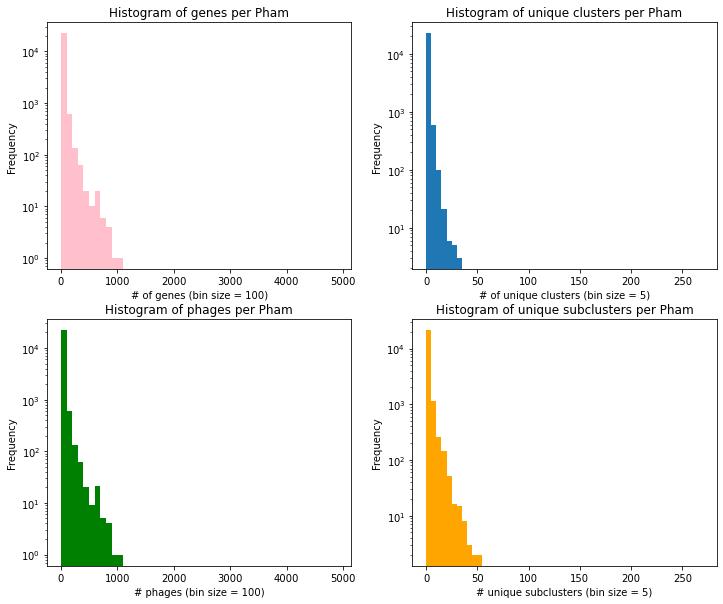

In [14]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

functions = sorted(list(df_genes["Pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(G.nodes[i]["clusters"]))

ax[0,0].hist(unique_cluster, bins=range(0,5000, 100), color = "pink")
ax[0,0].set_xlabel("# of genes (bin size = 100)")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_title("Histogram of genes per Pham")
ax[0,0].set_yscale('log')
print("\n Histogram of genes per Pham", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["Pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["clusters"])))
    
ax[0,1].hist(unique_cluster, bins=range(0,275,5))
ax[0,1].set_xlabel("# of unique clusters (bin size = 5)")
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_title("Histogram of unique clusters per Pham")
ax[0,1].set_yscale('log')
print("\n Histogram of unique clusters per Pham", scipy.stats.describe(unique_cluster))


functions = sorted(list(df_genes["Pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["phages"])))

ax[1,0].hist(unique_cluster, bins=range(0,5000, 100), color = "green")
ax[1,0].set_xlabel("# phages (bin size = 100)")
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_title("Histogram of phages per Pham")
ax[1,0].set_yscale('log')
print("\n Histogram of phages per Function", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["Pham"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["subclusters"])))
    
ax[1,1].hist(unique_cluster, bins=range(0,275,5), color = "orange")
ax[1,1].set_xlabel("# unique subclusters (bin size = 5)")
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_title("Histogram of unique subclusters per Pham")
ax[1,1].set_yscale('log')
print("\n Histogram of unique subclusters per Pham", scipy.stats.describe(unique_cluster))


plt.show()

###### Genes/Clusters per Function


 Histogram of genes per Function DescribeResult(nobs=1788, minmax=(1, 244309), mean=194.8271812080537, variance=33537565.037268598, skewness=41.93260003126703, kurtosis=1764.7906187174262)

 Histogram of unique clusters per Function DescribeResult(nobs=1788, minmax=(1, 140), mean=4.327181208053691, variance=145.2611074388856, skewness=6.643016806366868, kurtosis=52.861997071382504)

 Histogram of phages per Function DescribeResult(nobs=1788, minmax=(1, 3510), mean=48.20190156599553, variance=63692.97712005298, skewness=8.684851474551403, kurtosis=85.12509104014285)

 Histogram of unique subclusters per Function DescribeResult(nobs=1788, minmax=(1, 274), mean=6.510626398210291, variance=501.51919311607946, skewness=7.349840664445947, kurtosis=63.593516155224904)


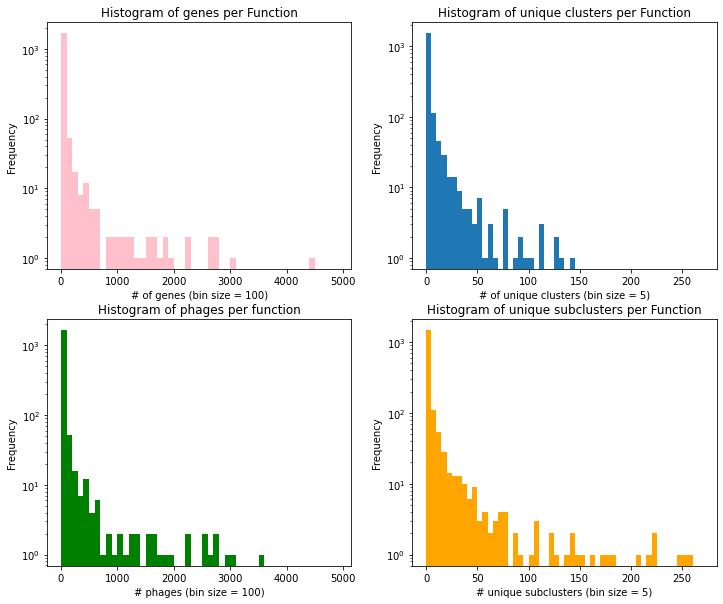

In [15]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

functions = sorted(list(df_genes["Function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(G.nodes[i]["clusters"]))

ax[0,0].hist(unique_cluster, bins=range(0,5000, 100), color = "pink")
ax[0,0].set_xlabel("# of genes (bin size = 100)")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_title("Histogram of genes per Function")
ax[0,0].set_yscale('log')
print("\n Histogram of genes per Function", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["Function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["clusters"])))
    
ax[0,1].hist(unique_cluster, bins=range(0,275,5))
ax[0,1].set_xlabel("# of unique clusters (bin size = 5)")
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_title("Histogram of unique clusters per Function")
ax[0,1].set_yscale('log')
print("\n Histogram of unique clusters per Function", scipy.stats.describe(unique_cluster))


functions = sorted(list(df_genes["Function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["phages"])))

ax[1,0].hist(unique_cluster, bins=range(0,5000, 100), color = "green")
ax[1,0].set_xlabel("# phages (bin size = 100)")
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_title("Histogram of phages per function")
ax[1,0].set_yscale('log')
print("\n Histogram of phages per Function", scipy.stats.describe(unique_cluster))

functions = sorted(list(df_genes["Function"].unique()))
unique_cluster = []
for i in functions:
    unique_cluster.append(len(np.unique(G.nodes[i]["subclusters"])))
    
ax[1,1].hist(unique_cluster, bins=range(0,275,5), color = "orange")
ax[1,1].set_xlabel("# unique subclusters (bin size = 5)")
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_title("Histogram of unique subclusters per Function")
ax[1,1].set_yscale('log')
print("\n Histogram of unique subclusters per Function", scipy.stats.describe(unique_cluster))


plt.show()


In [39]:
G.copy()


edge_cut_prop = np.linspace(0.01, 1.0, num=10)
true_ratio = []
false_ratio = []
true_count = []
false_count = []
total_count = []
for prop in edge_cut_prop:
    true = 0
    false = 0
    count = 0
    for i, j in G.edges():
        func = i if G.nodes[i]["group"] == "function" else j
        pham = i if G.nodes[i]["group"] == "pham" else j
        num_pham_members = G.nodes[pham]["freq"]
        if G.edges[i,j]["weight"]/num_pham_members < prop:
            if func.lower() in funcList:
                true += 1
            else:
                false += 1
            count += 1

    true_ratio += [true/count]
    false_ratio += [false/count]
    true_count += [true]
    false_count += [false]
    total_count += [count]

In [43]:
n = G.number_of_nodes()#function for number of nodes
m = G.size() #function for number of edges
kmean = m*2/n #mean of in directed degree is edges/number of nodes

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)

number of nodes, n  = 24996
number of edges, m  = 30119
mean degree,    <k> =  2.41


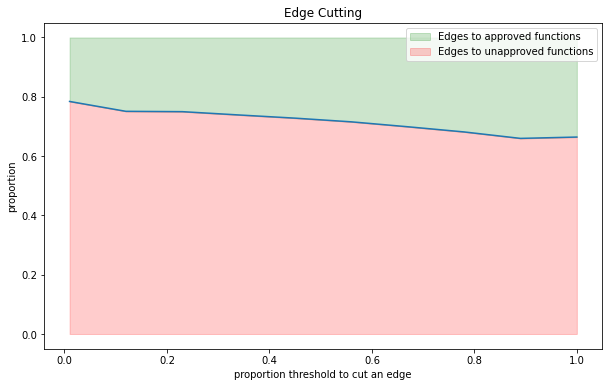

In [49]:
fig, ax = plt.subplots(figsize = (10,6))

plt.plot(edge_cut_prop, false_ratio)

plt.fill_between(edge_cut_prop, false_ratio, [1]*len(edge_cut_prop),
                 facecolor="green", # The fill color
                 color='green',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to approved functions")

plt.fill_between(edge_cut_prop, [0]*len(edge_cut_prop), false_ratio,
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to unapproved functions")


plt.ylabel("proportion")
plt.xlabel("proportion threshold to cut an edge")
plt.legend()


plt.title("Edge Cutting")
plt.show()

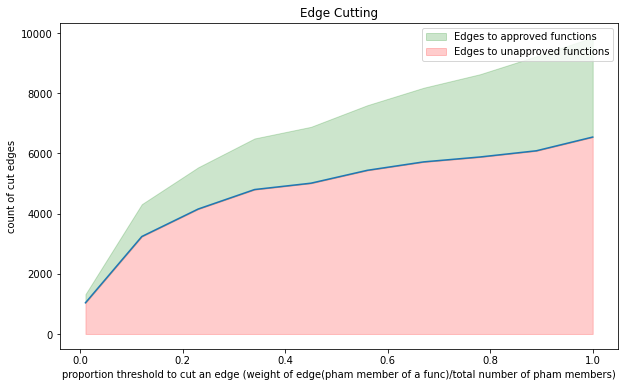

In [50]:
fig, ax = plt.subplots(figsize = (10,6))

plt.plot(edge_cut_prop, false_count)

plt.fill_between(edge_cut_prop, false_count, total_count,
                 facecolor="green", # The fill color
                 color='green',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to approved functions")

plt.fill_between(edge_cut_prop, [0]*len(edge_cut_prop), false_count,
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.2,          # Transparency of the fill
                 label = "Edges to unapproved functions")


plt.ylabel("count of cut edges")
plt.xlabel("proportion threshold to cut an edge (weight of edge(pham member of a func)/total number of pham members)")
plt.legend()

plt.title("Edge Cutting")
plt.show()

### Faulty Visualizations

In [17]:
cat = "Pham"
phams = sorted(list(df_genes[cat].unique()))
clusters = sorted(list(df_genes["Cluster"].unique()))

# empty array for results
a = [0]*df_genes["Cluster"].nunique()
pham_cluster = [a for _ in phams]

print(len(pham_cluster))
print(len(pham_cluster[0]))
#make a dict for clusters
for p in range(len(phams)):
    total = len(G.nodes[phams[p]]["clusters"])
    for c in range(len(clusters)):
        pham_cluster[p][c] = G.nodes[phams[p]]["clusters"].count(clusters[c])/total



23208
274


/Users/skymartin/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)


<AxesSubplot:>

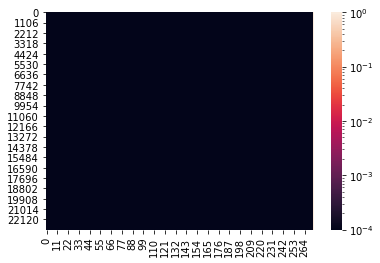

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import seaborn as sn
import matplotlib.colors as colors

import math
data =  np.array(pham_cluster) + 0.0001

log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

sn.heatmap(
    data,
    norm=log_norm,
    cbar_kws={"ticks": cbar_ticks}
)

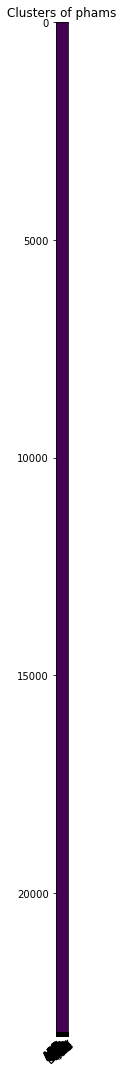

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(pham_cluster)

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
# ax.set_yticks(np.arange(len(pham)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
# ax.set_yticklabels(pham)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(len(pham)):
#     for j in range(len(clusters)):
#         text = ax.text(j, i, pham_cluster[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Clusters of phams")
fig.tight_layout()
plt.show()

In [20]:
# https://networkx.github.io/documentation/stable/reference/generated/networkx.convert.from_dict_of_dicts.html#networkx.convert.from_dict_of_dicts
# dod = {0: {1: {"weight": 1}}}  # single edge (0,1)
# G = nx.from_dict_of_dicts(dod)

In [21]:
# DICT OF DICT APPROACH, DIDN'T WORK AS DESIRED BECAUSE IT ASSUMES DIRECTION
# dod = {}
# i = 0
# for _, row in df.iterrows(): 
#     if row["Pham"] in dod.keys() and row["Function"] in dod[row["Pham"]].keys():
#         dod[row["Pham"]][row["Function"]]["weight"] += 1
#         if row["Cluster"] in dod[row["Pham"]][row["Function"]]["clusters"].keys():
#             dod[row["Pham"]][row["Function"]]["clusters"][row["Cluster"]] += 1
#         else:
#             dod[row["Pham"]][row["Function"]]["clusters"][row["Cluster"]] = 1
        
#     elif row["Pham"] in dod.keys():
#         dod[row["Pham"]][row["Function"]] = {"weight":1, "clusters": {row["Cluster"]:1}}
#     else:
#         dod[row["Pham"]] = {row["Function"]:{"weight":1, "clusters": {row["Cluster"]:1}}}
#     i += 1
#     if i>3:
#         break
# print(dod)
# G = nx.from_dict_of_dicts(dod)
# nx.draw_networkx(G, node_size=2)

In [22]:
# nx.write_gexf(G, "Bipartite_Gene_Graph.gexf")

In [23]:
# make a mapping for ability to add values in matrix {value: index,...}
# pham_mapping = {}
# for p in range(len(phams)):
#     pham_mapping[phams[p]] = p
    
# cluster_mapping = {}
# for c in range(len(clusters)):
#     cluster_mapping[clusters[c]] = c